Identificar os coeficientes do MP já levando em consideração, durante a identificação, que as operações serão idênticas às da FPGA, ou seja, manipulam-se apenas números inteiros e usam-se apenas somadores e multiplicadores de 2 entradas. Usar a estrutura de function feita na Atividade M2. Importante: a remoção de metade dos bits após cada multiplicação é uma operação não linear e por isso justifica-se usar um otimizador não linear. O objetivo é encontrar coeficientes que são números inteiros, então buscar por um otimizador não linear inteiro.

In [1]:
from scipy.io import loadmat
import numpy as np

mat = loadmat('in_out_SBRT2_direto.mat')

in_data_ext = mat['in_extraction'].flatten()
out_data_ext = mat['out_extraction'].flatten()
in_data_val = mat['in_validation'].flatten()
out_data_val = mat['out_validation'].flatten()

lista = [in_data_ext, out_data_ext, in_data_val, out_data_val]

modulos = []
for i in lista:
    modulos.append(max(i.imag))
    modulos.append(max(i.real))

maior_modulo = max(modulos)

in_ext_norm  = in_data_ext / maior_modulo
out_ext_norm = out_data_ext / maior_modulo
in_val_norm  = in_data_val / maior_modulo
out_val_norm = out_data_val / maior_modulo


p_bits = 20
    
in_val_fixed = np.round(in_val_norm * (2 ** p_bits)) 
out_val_fixed = np.round(out_val_norm * (2 ** p_bits))


In [52]:

import numpy as np

def erro_mp_complex_float(params, x_in, y_out, ordem, memoria):
    num_coef = ordem * (memoria+1)
    # Reconstruct complex params
    ar = params[:num_coef]
    ai = params[num_coef:]
    coefs = ar + 1j*ai

    N = len(x_in)
    y_est = np.zeros(N, dtype=complex)

    idx = 0
    for k in range(memoria+1):
        xk = np.roll(x_in, k)
        for p in range(1, ordem+1):
            y_est += coefs[idx] * (xk * np.abs(xk)**((p-1)*2))
            idx += 1

    erro = y_out - y_est
    return np.abs(erro)**2


In [53]:
from scipy.optimize import least_squares

ordem = 3
memoria = 2
num_coef = ordem * (memoria+1)

# Vetor inicial: separar parte real e imaginária
params = 0.01*np.random.randn(2*num_coef)

res = least_squares(
    erro_mp_complex_float,
    params,
    args=(in_ext_norm, out_ext_norm, ordem, memoria),
    verbose=2
)

coef_otimo = res.x[:num_coef] + 1j*res.x[num_coef:]
print("Coeficientes complexos otimizados:", coef_otimo)

# Calcular MSE na validação
erro_val = erro_mp_complex_float(res.x, in_data_val, out_data_val, ordem, memoria)
mse_val = np.mean(erro_val**2)
print("MSE validação:", mse_val)


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.6649e+02                                    7.96e+02    
       1              2         9.4220e+01      7.23e+01       5.46e-02       5.18e+02    
       2              3         2.3729e+01      7.05e+01       1.09e-01       1.78e+02    
       3              4         1.9888e+00      2.17e+01       2.18e-01       2.48e+01    
       4              5         1.7817e-01      1.81e+00       4.37e-01       3.77e+00    
       5              6         3.6204e-02      1.42e-01       8.73e-01       8.09e-01    
       6              7         5.2760e-03      3.09e-02       6.20e-01       7.91e-02    
       7              9         4.9351e-03      3.41e-04       3.05e-01       8.58e-02    
       8             10         3.9200e-03      1.02e-03       7.63e-02       8.94e-02    
       9             12         3.2850e-03      6.35e-04       1.91e-02       4.88e-02    

valor de NMSE: -25.499980070582396


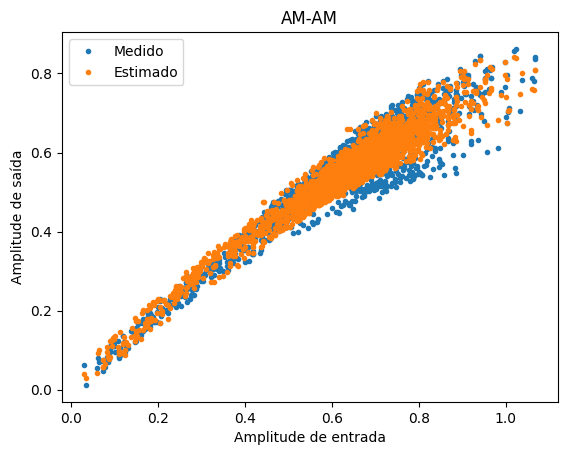

In [ ]:
import matplotlib.pyplot as plt
nmse_calculo = lambda predicted_val, data_out, M:10 * np.log10(np.mean(np.abs(data_out[M:] - predicted_val) ** 2) / np.mean(np.abs(data_out[M:]) ** 2))

def mp(P, M, xn, coef):
    L = xn.shape[0]

    y_est = np.zeros(L, dtype=complex)
    idx = 0
    for k in range(memoria+1):
        xk = np.roll(xn, k)
        for p in range(1, P+1):
            y_est += coef[idx] * (xk * np.abs(xk)**((p-1)*2))
            idx += 1
    return y_est


predicted_val = mp(ordem, memoria, in_val_norm, coef_otimo)

nmse_target = nmse_calculo(predicted_val[memoria:], out_val_norm, memoria)

print(f"valor de NMSE: {nmse_target}")

plt.figure()
plt.plot(np.abs(in_val_norm[memoria:]), np.abs(out_val_norm[memoria:]), '.', label='Medido')
plt.plot(np.abs(in_val_norm[memoria:]), np.abs(predicted_val[memoria:]), '.', label='Estimado')
plt.xlabel('Amplitude de entrada')
plt.ylabel('Amplitude de saída')
plt.title('AM-AM')
plt.legend()

plt.show()

In [58]:
def modulo_preservando_sinal(dividendo, divisor):
    resto = dividendo % divisor
    return resto if dividendo >= 0 else resto - divisor

def readeq_int(val, precision):
    """Readequação de bits (divisão por 2**precision, truncando)."""
    return int(val) >> precision


# Reconstruindo o modelo para validação já quantizado
def aplica_modelo_int(x, coef_int, ordem, memoria, precision):
    N = len(x)
    idx = 0
    y_est = np.zeros(N, dtype=complex)

    for n in range(memoria, N):
        soma_real : int = 0
        soma_imag : int = 0
        idx = 0

        for m in range(memoria+1):
            for p in range(1, ordem+1):
                # calcula x_in^(p)
                xr = int(np.real(x[n-m]))
                xi = int(np.imag(x[n-m]))
                # potência complexa com readequação a cada multiplicação
                modulo_power = 2**precision 
                modulo_square = readeq_int(xr ** 2, precision) + readeq_int(xi ** 2, precision)
                for _ in range(1, p):
                    modulo_power = readeq_int(modulo_power * modulo_square, precision)
                xr_p = modulo_preservando_sinal(readeq_int(xr * modulo_power,precision), 2**precision) 
                xi_p = modulo_preservando_sinal(readeq_int(xi * modulo_power,precision), 2**precision) 

                # multiplicação coef * x^p com readequação
                ar = int(np.real(coef_int[idx]))
                ai = int(np.imag(coef_int[idx]))

                prod_real = readeq_int(ar * xr_p - ai * xi_p, precision)
                prod_imag = readeq_int(ar * xi_p + ai * xr_p, precision)

                soma_real += prod_real
                soma_imag += prod_imag
                idx += 1

        y_est[n] = int(soma_real) + 1j * int(soma_imag)

    return y_est

    

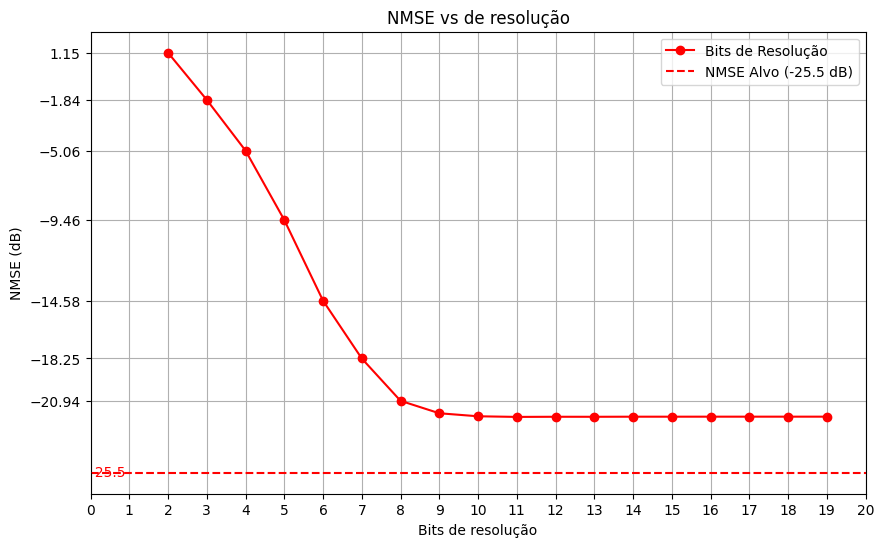

In [61]:
nmse_values = []

for p_bits in range(2, 20):
    # print(f'{np.round(coefficients * (2 ** p_bits))}')
    scale = 2**p_bits
    coef_int = np.round(coef_otimo * scale)
    in_data_val_fixed = np.round(in_val_norm * scale) 
    out_data_val_fixed = np.round(out_val_norm * scale)

    # print(f"Coeficientes inteiros quantizados: {coef_int}")
    pred_val_int = aplica_modelo_int(in_data_val_fixed, coef_int, ordem, memoria, p_bits)
    mse_val_int = nmse_calculo(pred_val_int[memoria:], out_data_val_fixed, memoria)

    # print("MSE validação quantizado:", mse_val_int)
    nmse_values.append((p_bits, mse_val_int))

nmse_values = np.array(nmse_values)
resol_bits_array = nmse_values[:, 0]
nmse_fixed_array = nmse_values[:, 1]

plt.figure(figsize=(10, 6))
# plt.plot(total_bits_array, nmse_fixed_array, marker='o', linestyle='-', color='b', label='Bits Totais')
plt.plot(resol_bits_array, nmse_fixed_array, marker='o', linestyle='-', color='r', label='Bits de Resolução')

# Adicionar títulos e labels
plt.title('NMSE vs de resolução')
plt.xlabel('Bits de resolução')
plt.ylabel('NMSE (dB)')
plt.xticks(np.arange(0, max(resol_bits_array) + 2, 1))
plt.yticks(nmse_fixed_array[:7])

plt.axhline(y=nmse_target, color='r', linestyle='--', label=f'NMSE Alvo ({nmse_target:.4} dB)')
plt.text(0, nmse_target, f'{nmse_target:.4}', color='r', verticalalignment='center')

plt.legend()
plt.grid(True)
plt.show()

In [6]:

import numpy as np

def modulo_preservando_sinal(dividendo, divisor):
    resto = dividendo % divisor
    return resto if dividendo >= 0 else resto - divisor

def readeq_int(val, precision):
    """Readequação de bits (divisão por 2**precision, truncando)."""
    return int(val) >> precision

def erro_mp_complex_int(params, x_in, y_out, ordem, memoria, precision):
    N = len(x_in)
    idx = 0
    y_est = np.zeros(N, dtype=complex)

    for n in range(memoria, N):
        soma_real : int = 0
        soma_imag : int = 0
        idx = 0

        for m in range(memoria+1):
            for p in range(1, ordem+1):
                # calcula x_in^(p)
                xr = int(np.real(x_in[n-m]))
                xi = int(np.imag(x_in[n-m]))
                # potência complexa com readequação a cada multiplicação
                modulo_power = 2**precision 
                modulo_square = readeq_int(xr ** 2, precision) + readeq_int(xi ** 2, precision)
                for _ in range(1, p):
                    modulo_power = readeq_int(modulo_power * modulo_square, precision)
                xr_p = modulo_preservando_sinal(readeq_int(xr * modulo_power,precision), 2**precision) 
                xi_p = modulo_preservando_sinal(readeq_int(xi * modulo_power,precision), 2**precision) 

                # multiplicação coef * x^p com readequação
                ar = int(np.real(params[idx]))
                ai = int(np.imag(params[idx]))

                prod_real = readeq_int(ar * xr_p - ai * xi_p, precision)
                prod_imag = readeq_int(ar * xi_p + ai * xr_p, precision)

                soma_real += prod_real
                soma_imag += prod_imag
                idx += 1

        y_est[n] = int(soma_real) + 1j * int(soma_imag)

    erro = y_out - y_est
    return np.abs(erro)**2

# Extração de Coeficientes com 8 bits de resolução

In [ ]:
from scipy.optimize import least_squares

ordem = 3
memoria = 2
precision = 8
num_coef = ordem * (memoria+1)


scale = 2**precision
in_data_extract_fixed = np.round(in_ext_norm * scale) 
out_data_extract_fixed = np.round(out_ext_norm * scale)
# Vetor inicial: separar parte real e imaginária
params = scale*np.random.randn(2*num_coef)


res = least_squares(
    erro_mp_complex_int,
    params,
    args=(in_data_extract_fixed, out_data_extract_fixed, ordem, memoria, precision),
    verbose=2
)

coef_otimo = res.x[:num_coef] + 1j*res.x[num_coef:]
print("Coeficientes complexos otimizados:", coef_otimo)



   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         8.5193e+13                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 8.5193e+13, final cost 8.5193e+13, first-order optimality 0.00e+00.
Coeficientes complexos otimizados: [ -73.55060987-197.42631844j -286.09326524+276.76790276j
 -261.01401551 -36.45251262j -249.96114756-175.39527372j
  355.28746819-369.07243992j  -99.47661343-355.14672107j
  -51.5493171 +242.13944925j -184.22078511 -24.6310806j
  -45.01191983-208.21192729j]


valor de NMSE: 241.994555373202


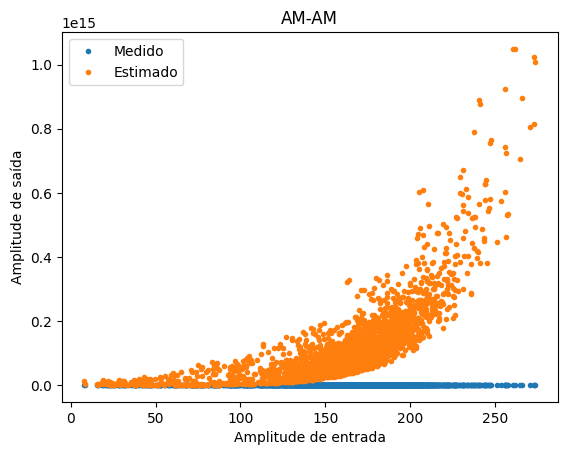

In [10]:
import matplotlib.pyplot as plt
nmse_calculo = lambda predicted_val, data_out, M:10 * np.log10(np.mean(np.abs(data_out[M:] - predicted_val) ** 2) / np.mean(np.abs(data_out[M:]) ** 2))

def mp(P, M, xn, coef):
    L = xn.shape[0]

    y_est = np.zeros(L, dtype=complex)
    idx = 0
    for k in range(memoria+1):
        xk = np.roll(xn, k)
        for p in range(1, P+1):
            y_est += coef[idx] * (xk * np.abs(xk)**((p-1)*2))
            idx += 1
    return y_est



in_data_val_fixed = np.round(in_val_norm * scale) 
out_data_val_fixed = np.round(out_val_norm * scale)
predicted_val = mp(ordem, memoria, in_data_val_fixed, coef_otimo)

nmse_target = nmse_calculo(predicted_val[memoria:], out_data_val_fixed, memoria)

print(f"valor de NMSE: {nmse_target}")

plt.figure()
plt.plot(np.abs(in_data_val_fixed[memoria:]), np.abs(out_data_val_fixed[memoria:]), '.', label='Medido')
plt.plot(np.abs(in_data_val_fixed[memoria:]), np.abs(predicted_val[memoria:]), '.', label='Estimado')
plt.xlabel('Amplitude de entrada')
plt.ylabel('Amplitude de saída')
plt.title('AM-AM')
plt.legend()

plt.show()